# Failure probability

## This script does the following
* Approximates a failure probability using the surrogate-NL with and without importance sampling

## Problem description

Consider the linear-linear coupled Poisson problem described in (3.2) but with \newline $\mathcal{P}=[0 \ 0.5]\times [0 \ 0.25]\times [0.001 \ 0.1]$. Let the output of interest be given by the average value on the interface. This can be approximated using the solutions from the surrogate model, that is
\begin{align}
    F(u({x};{\mu})) &= \frac{1}{|\Gamma|} \int_{\Gamma} u({x};{\mu}) \ d\Gamma \\
         &\approx \frac{1}{N_\Gamma} \sum_{j=1}^{N_\Gamma} U_\Gamma^{rb,(i)}. \nonumber
\end{align}
Suppose we assign a $1$ (failure) for when the output of interest is greater than $3.9$ and assign $0$ (success) else. This gives 
\begin{align}
\label{eq:failprob}
G(u({x};{\mu})) =
    \begin{cases}
        1 & \text{if} \quad F(u({x};{\mu})) > F_0 = 3.9,  \\
        0 & \text{else}.
    \end{cases}
\end{align}
The quantity of interest is the failure probability, that is
\begin{align}
\label{eq:qoifail}
    P_{F_0} = P[F(u({x};{\mu})) \geq F_0] = \int_\mathcal{P} G(u({x};{\mu}))\rho(\mu) \ d{\mu}. 
\end{align}

Using regular Monte Carlo simulation, the failure probability is approximated such that
\begin{align*}
    P_{F_0} \approx P_{F_0,MC} = \frac{1}{Q}\sum_{q=1}^Q G({U}^{rb}({x};{\mu}^q)).
\end{align*}

Using importance sampling, the failure probability is approximated so that
\begin{align*}
    P_{F_0} \approx P_{F_0,IS} =  \frac{1}{Q}\sum_{i=1}^Q G({U}^{rb}({x};{\mu}^i)\frac{\rho({\mu}^i)}{q({\mu}^i)}.
\end{align*}

In [2]:
%run functions.ipynb

# Offline stage

# Create FOM snapshots and 100 test samples

In [3]:
# Choose number of snapshots and test samples
ntest = 100
nsamples = 500 + ntest

alreadyrun = 1

if not alreadyrun:
    %run FOM_snapshots_LL_P1.ipynb

    # Open a file and use dump()
    variables = [S, S1, SI, S2, A_1I, A_11, A_II1, F_1, mu, F_2I_array, f_I, snapshots_time]

    with open('offline_vars.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('offline_vars.pkl', 'rb') as file:

        # Call load method
        S, S1, SI, S2, A_1I, A_11, A_II1, F_1, mu, F_2I_array, f_I, snapshots_time = pickle.load(file)

# Perform POD analysis

Snapshot energy domain 1: 0.9983769355755766
Snapshot energy domain 2: 0.939404327654718
Snapshot energy interface: 0.9948292931577204


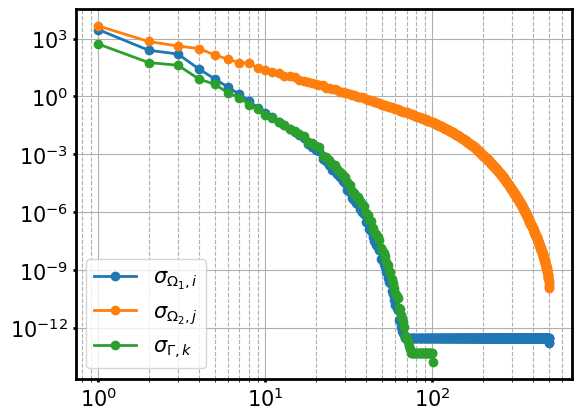

In [5]:
cutoff1 = 5
cutoffI = 5
cutoff2 = 5

V_1, V_I, V_2, ndofs_u1, ndofs_uI, ndofs_u2, u1, uI, u2 = POD_all(S1, SI, S2, cutoff1, cutoffI, cutoff2)

# Train neural network for $\hat{\pi}_\Gamma$

In [7]:
alreadyrun = 1

if not alreadyrun:

    torch_inputs = torch.from_numpy(mu[0:nsamples-ntest,:]).float()
    n_epochs = 1000
    learning_rate = 0.001

    torch_outputs = torch.from_numpy(uI[0:nsamples-ntest,:]).float()
    uI_model4, uI_model4time, loss = Neural_Network(torch_inputs, torch_outputs, n_epochs, learning_rate)
    variables = [uI_model4, uI_model4time]


    with open('ugamma4.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('ugamma4.pkl', 'rb') as file:

        # Call load method
        uI_model4, uI_model4time = pickle.load(file)

# Compute OoI

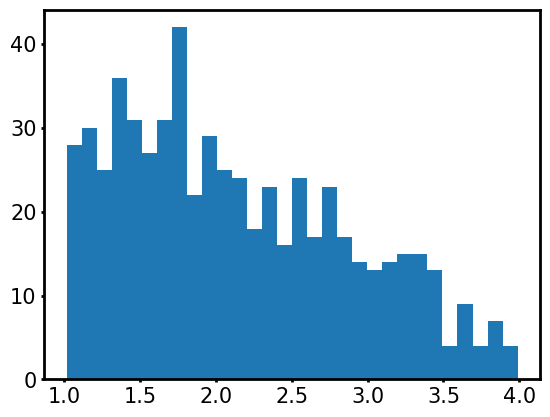

In [8]:
OoI_array = np.zeros((nsamples))
for i in range(nsamples):
    OoI = np.mean(SI[:,i])
    OoI_array[i] = OoI
    
plt.hist(OoI_array, bins=30)
plt.show()

In [11]:
mu_star = mu[np.argmax(OoI_array)]

# Based on the above we create a new problem:

# Determine the failure probability when 

$$
F(\mu) > F_0 = 3.9
$$

# Change the probability distributions

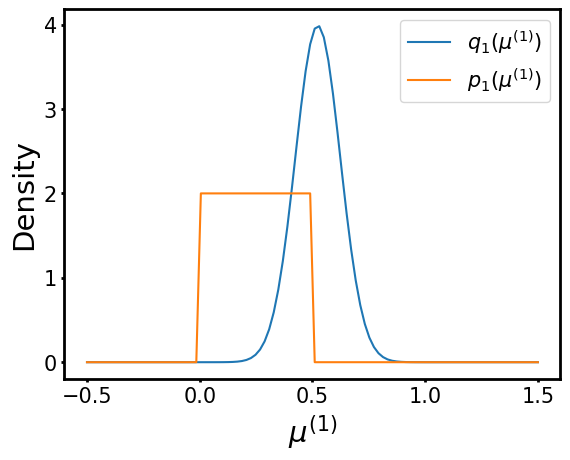

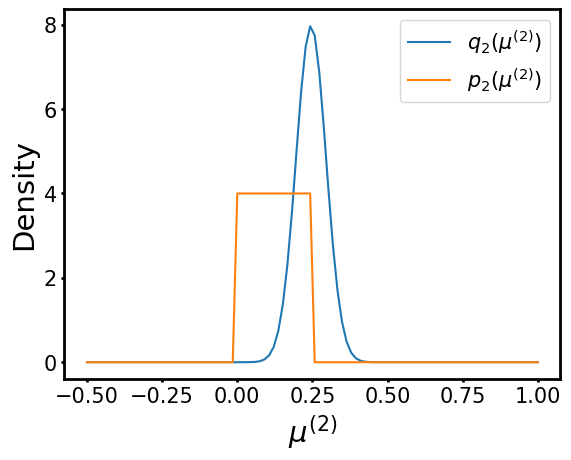

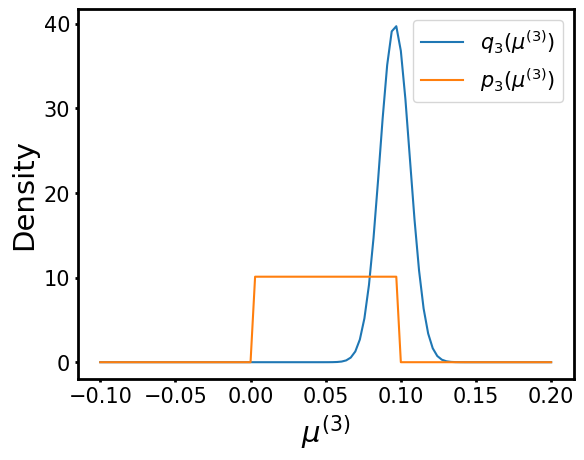

In [12]:
var1 = 0.1
var2 = 0.05
var3 = 0.01

x1 = np.linspace(-0.5, 1.5, num=100)
y1 = np.zeros((len(x1)))
y2 = np.zeros((len(x1)))
for idx, val in enumerate(x1):
    y = f_normal(val, mu_star[0], var1)
    y2_iter = uni_dist(val, 0, 0.5)
    y1[idx] = y
    y2[idx] = y2_iter

    
fig1 = plt.plot(x1, y1)
plt.plot(x1, y2)
plt.legend(['$q_1(\mu^{(1)})$', '$p_1(\mu^{(1)})$'])
plt.xlabel('$\mu^{(1)}$')
plt.ylabel('Density')
plt.savefig('bias1.png', bbox_inches='tight')

plt.show()


x1 = np.linspace(-0.5, 1, num=100)
y1 = np.zeros((len(x1)))
y2 = np.zeros((len(x1)))
for idx, val in enumerate(x1):
    y = f_normal(val, mu_star[1], var2)
    y2_iter = uni_dist(val, 0, 0.25)
    y1[idx] = y
    y2[idx] = y2_iter

    
fig2 = plt.plot(x1, y1)
plt.plot(x1, y2)
plt.legend(['$q_2(\mu^{(2)})$', '$p_2(\mu^{(2)})$'])
plt.xlabel('$\mu^{(2)}$')
plt.ylabel('Density')
plt.savefig('bias2.png', bbox_inches='tight')

plt.show()


x1 = np.linspace(-0.1, .2,num=100)
y1 = np.zeros((len(x1)))
y2 = np.zeros((len(x1)))
for idx, val in enumerate(x1):
    y = f_normal(val, mu_star[2], var3)
    y2_iter = uni_dist(val, 0.001, 0.1)
    y1[idx] = y
    y2[idx] = y2_iter

    
fig3 = plt.plot(x1, y1)
plt.plot(x1, y2)
plt.legend(['$q_3(\mu^{(3)})$', '$p_3(\mu^{(3)})$'])
plt.xlabel('$\mu^{(3)}$')
plt.ylabel('Density')
plt.savefig('bias3.png', bbox_inches='tight')

plt.show()


# Create Monte Carlo samples

In [14]:
# Choose number of snapshots and test samples
ntest = 0
nsamples = 60000 + ntest

alreadyrun = 1
importance_sampling = 1

if not alreadyrun:
    %run Importance_Sampling_FOM.ipynb

    # Open a file and use dump()
    variables = [mu, SI]

    with open('MC.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('MC.pkl', 'rb') as file:

        # Call load method
        mu, SI = pickle.load(file)

# Online stage: surrogate-NL

In [15]:
OoI_array_ROM = np.zeros((nsamples))

a_11 = np.matmul(np.matmul(V_1.T,A_11.toarray()),V_1)
a_1I = np.matmul(np.matmul(V_1.T,A_1I.toarray()),V_I)
f_1 = np.matmul(V_1.T,F_1)

QoIs = np.zeros((nsamples))

MC_IS = 0

for j in range(nsamples):
    print("Sample",j,end="\r")
    
    # ROM
    mu_test = mu[j]
    u_I_pred_m4 = uI_model4(torch.from_numpy(mu_test).float()).detach().numpy()
    u_I_predh_m4 = np.matmul(V_I,u_I_pred_m4)

    
    OoI = np.mean(u_I_predh_m4)
    if OoI > 3.9:
        OoI = 1
    else:
        OoI = 0
        
    OoI_array_ROM[j] = OoI
    
    q1 = f_normal(mu[j,0], mu_star[0], var1)
    q2 = f_normal(mu[j,1], mu_star[1], var2)
    q3 = f_normal(mu[j,2], mu_star[2], var3)
    
    p1 = uni_dist(mu[j, 0], 0, 0.5)
    p2 = uni_dist(mu[j, 1], 0, 0.25)
    p3 = uni_dist(mu[j, 2], 0.001, 0.1)
    
    val = OoI*((p1*p2*p3)/(q1*q2*q3))
    MC_IS += val 
    
    QoI_iter = MC_IS/(j+1)
    QoIs[j] = QoI_iter

QoI = MC_IS/nsamples

# Without Importance sampling

In [16]:
# Choose number of snapshots and test samples
ntest = 0
nsamples = 60000 + ntest

# Choose LL-coupled problem 1 or thermal block
importance_sampling = 0
alreadyrun = 1

if not alreadyrun:
    %run Importance_Sampling_FOM.ipynb

    # Open a file and use dump()
    variables = [mu, SI]

    with open('MC_noIS.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('MC_noIS.pkl', 'rb') as file:

        # Call load method
        mu, SI = pickle.load(file)

In [17]:
OoI_array_ROM_nois = np.zeros((nsamples))

a_11 = np.matmul(np.matmul(V_1.T,A_11.toarray()),V_1)
a_1I = np.matmul(np.matmul(V_1.T,A_1I.toarray()),V_I)
f_1 = np.matmul(V_1.T,F_1)

QoIs_nois = np.zeros((nsamples))
MC_nois = 0

for j in range(nsamples):
    print("Sample",j,end="\r")
    
    # ROM
    mu_test = mu[j]
    u_I_pred_m4 = uI_model4(torch.from_numpy(mu_test).float()).detach().numpy()
    u_I_predh_m4 = np.matmul(V_I,u_I_pred_m4)

    
    OoI = np.mean(u_I_predh_m4)
    if OoI > 3.9:
        OoI = 1
    else:
        OoI = 0
            
    MC_nois += OoI 
    
    QoI_iter = MC_nois/(j+1)
    QoIs_nois[j] = QoI_iter
    


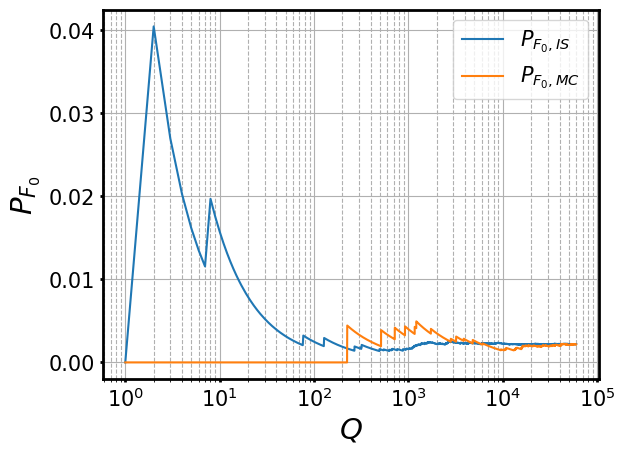

In [18]:
xaxis = np.arange(1,nsamples+1)

plt.plot(xaxis,QoIs, label= '$P_{F_0, IS}$')
plt.plot(xaxis,QoIs_nois, label= '$P_{F_0, MC}$')
plt.ylabel('$P_{F_0}$')
plt.xlabel('$Q$')

plt.xscale('log')
# plt.title('Estimation of the failure probabilty',fontsize='20')
plt.grid(True, which='major', linestyle='-')
plt.grid(True, which='minor', linestyle='--')
plt.legend()
plt.savefig('failureprobability.png', bbox_inches='tight')

plt.show()
